In [1]:
%matplotlib notebook

import os, sys, math, string
from sympy.ntheory import primefactors, factorint
from timeit import default_timer as timer #for timing

import numpy as np
from scipy.constants import e #in Coulomb
#from scipy.interpolate import interp1d

import matplotlib.pyplot as plt #for plotting

import imageio

#for CUDA:
from numba import cuda
from numba import * #I don't know why I have to split the cell here when I import all the lib *!
#continue to cell below...

In [2]:
#...from cell above
from __future__ import print_function

import pycuda.autoinit
import pycuda.driver as cudadriver
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

#for using FFT with scikitcuda:
import skcuda.fft as cu_fft
import skcuda.linalg as linalg

# lib written by me:
os.chdir('../ebl')
import PatternGenerator as pg
from Casino import Casino3 as cs3


/home/luan/anaconda3/envs/pycudaenv_py36/lib/python3.6/site-packages/scikit_cuda-0.5.3-py3.6.egg/skcuda/cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [3]:
# some useful functions

## getting probe current on Zeiss Supra 40 SEM
### beam current (pA) at largest aperture for 30, 20, 10 and 5 kV:
MAX_CURRENT_30 = 7300 
MAX_CURRENT_20 = 4340
MAX_CURRENT_10 = 2750
MAX_CURRENT_5 = 2000

# below these two functions are for a typical SEM Zeiss Supra 40:
def getpc(kV, maxpc,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    maxpc : beam current at biggest aperture (pA).
    ap : list of aperture diameters (µm).
    example : getpc(30,7300) return an array of beam currents for different aperture sizes.'''
    im = len(ap)-2
    pc=np.array([maxpc]*(im+2))
    for ii in np.arange(im,-1,-1):
        pc[ii] = pc[ii+1]*(ap[ii]/ap[ii+1])**2
    return pc

def getpc2(kV, pci,i,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    pci : beam current (pA) at ith aperture. i=0 is the smallest aperture.
    ap : list of aperture diameters (µm).
    example : getpc(30,456,3) return an array of beam currents for different aperture sizes.'''
    assert i >= 0 and i < len(ap)
    pc=np.array([0]*len(ap))
    pc[i] = pci
    pc[-1] = pc[i]*(ap[-1]/ap[i])**2
    for ii2 in np.arange(len(ap)-2,-1,-1):
        pc[ii2] = pc[ii2+1]*(ap[ii2]/ap[ii2+1])**2
    return pc

In [24]:
## for kernel use:
def i2f(idx,WF,px_size):
    '''It is the reverse function of float2idx.'''
    return -WF/2+idx*px_size

def f2i(x,WF,px_size):
    '''It just converts a float value to index integer in the array of WF.'''
    return int((x+WF/2)/px_size)

f2i_gpu = cuda.jit(device=True)(f2i)

@cuda.jit
def pattern2matrix(dest, pattern, WF, pxs):
    '''Map the pattern to matrix data.
    It will also correct redundance dots in pattern.'''
    i = cuda.grid(1)
    ix = f2i_gpu(pattern[i,0],WF,pxs)
    iy = f2i_gpu(pattern[i,1],WF,pxs)
    dest[ix,iy] += pattern[i,2]

def psf_interp1(r,sr,M,data):
    '''You don't need to use this function.
    It's a subroutine for kernel to interpolate points in beetwen two simulated data.'''
    r_i = r/sr
    i_lo=int(r_i);i_hi = i_lo+1 if r_i > i_lo else i_lo
    if i_hi >= M:
        return 0.0
    elif i_hi == i_lo:
        return data[i_hi,1]
    else:
        slope = (data[i_hi,1]-data[i_lo,1])/(data[i_hi,0]-data[i_lo,0])
        return slope*(r-data[i_lo,0]) + data[i_lo,1]

psf_interp1_gpu = cuda.jit(device=True)(psf_interp1)

@cuda.jit
def psf_kernel(psf,point,NP,WF,pixel_size,sr,nr,simdata):
    '''This kernel stores the PSF function in the psf 2D-array. Whole WF version.
    point: only a dot at (x=0,y=0,dose=1) the center of the writefield (WF).
    NP: number of pixel in one dimension of WF. Here we work on a square 2D-array.
    for saving the GPU time, I think it's better to give the size of the pixel instead of letting the kernel calculate it.
    sr, nr are the step and the number of points respectivly in the electron-range direction of the simulated data, simdata.
    simdata: simulated data by Casino. its shape is two columns: one for x and one for y (the deposited energy at point x).
    '''
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y
    for ix in range(startX, NP, gridX):
        val_x = -WF/2 + ix*pixel_size
        for iy in range(startY, NP, gridY):
            val_y = -WF/2 + iy*pixel_size
            r = math.sqrt((val_x-point[0])**2+(val_y-point[1])**2)
            psf[iy, ix] += point[2]*psf_interp1_gpu(r,sr,nr,simdata)

@cuda.jit
def partial_psf_kernel(dest,point,NP,min_x, min_y,pixel_size,sr,nr,dosedata):
    '''This kernel stores the PSF function in the psf 2D-array. Corner version.
    NP is related to pixel_size; min_x, min_y is the lower-left corner.'''
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y
    for ix in range(startX, NP, gridX):
        val_x = min_x + ix*pixel_size
        for iy in range(startY, NP, gridY):
            val_y = min_y + iy*pixel_size
            r = math.sqrt((val_x-point[0])**2+(val_y-point[1])**2)
            dest[iy, ix] += point[2]*psf_interp1_gpu(r,sr,nr,dosedata)

In [5]:
## Miscellaneous:
def getdepthZ(zi,sim):
    return zi*sim.sz+sim.zrange[0]

def idx2val(simdata,idx=0,axis=2):
    '''ouput the value belong to axis (0=x; 1=y; 2=z).
    use case: idx2val(sim.data,3,2).'''
    assert isinstance(simdata,np.ndarray)
    assert isinstance(idx, int)
    assert isinstance(axis, int)
    assert axis < 3 and axis >=0
    if len(simdata.shape) != 3:
        print("not a 3D-data!")
        return
    if idx >= simdata.shape[axis]:
        print("index out of range")
        return
    else:
        if axis == 0:
            return sim.xrange[0]+idx*sim.sx
        elif axis == 1:
            return sim.yrange[0]+idx*sim.sy
        else:
            return sim.zrange[0]+idx*sim.sz

def dtfactor(dose,step_size,current,speed=6):
    '''return the dwelltime factor (dt/dt0).
    dose in µC/cm²; step_size in nm; current in pA and speed in MHz.'''
    return speed*step_size**2*dose/current/100

def mylocalplot(z,xc,yc,WF,swf,pxs):
    assert swf <= WF
    if xc > ((WF-swf)/2):
        xc = (WF-swf)/2
    if xc < ((swf-WF)/2):
        xc = (swf-WF)/2
    if yc > ((WF-swf)/2):
        yc = (WF-swf)/2
    if yc < ((swf-WF)/2):
        yc = (swf-WF)/2
    ix=f2i(yc,WF,pxs)
    iy=f2i(xc,WF,pxs)
    ni=int(swf/pxs)-1
    plt.imshow(z[ix-ni//2:ix+ni//2,iy-ni//2:iy+ni//2],origin='lower', extent=[xc-swf/2, xc+swf/2, yc-swf/2, yc+swf/2],interpolation="nearest", cmap=plt.cm.jet)
    plt.show()
    return

<IPython.core.display.Javascript object>


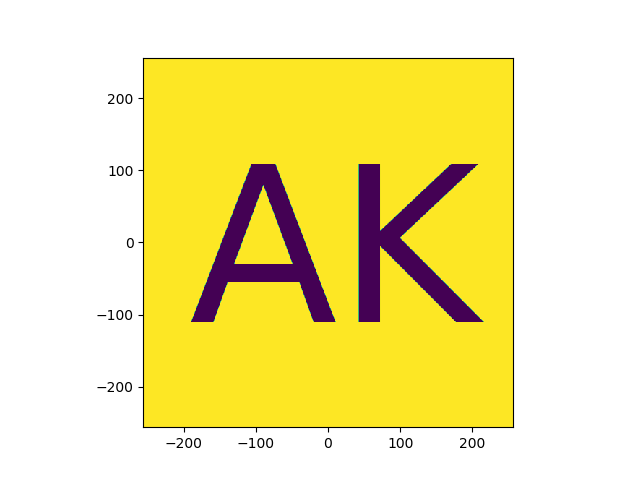

(0, 255)

In [6]:
os.chdir('../test')
z = imageio.imread('AK.png')
i=0;WF=512
plt.imshow(z[:,:,i],origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()
np.min(z[:,:,i]),np.max(z[:,:,i])

In [7]:
#SEM + EBL parameters:
Nesim=1e7 #number of simulated electron paths. Must be the same as in Casino3 software simulation parameters.
PGSpeed=6e6 #pattern generator (Raith Elphy Plus) max frequency in Hz

#semCurrentsAt30kV=np.array([24,48,196,411,1780,7300])*1e-12 #SEM currents tab in Ampere at 30 kV
semCurrentsAtkV=getpc(30,MAX_CURRENT_30)*1e-12 #SEM currents tab in Ampere at 30 kV

minimalDoses=semCurrentsAtkV/PGSpeed #in C
Nelectrons=minimalDoses/e
normalizeFactors=Nelectrons/Nesim

# import data from cs3:
os.chdir('../ebl/demo')
filename='zep520_1e7_30kV_100mrad_1pt'
sim=cs3(filename)

# create electron range array for X-axis:
r= np.arange(sim.xrange[0],sim.xrange[1],sim.sx)

# create XY array (for the smallest beam current multiply y-values by normalizeFactors[0]):
yi=3;zi=3 #half thickness of resist (150 nm)
mcdata=np.c_[r,1000*sim.data[:,yi,zi]*normalizeFactors[0]] #he unit of energy given by Casino3 is keV so *1000 to get eV

<IPython.core.display.Javascript object>


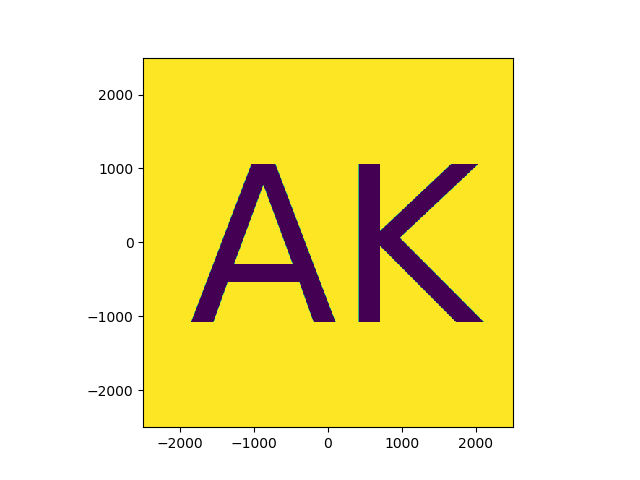

In [8]:
os.chdir('../../test')
dose_dis=z[:,:,0]/255
del z

WF=5000
plt.imshow(dose_dis,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

In [9]:
n=1
NP=n*512;WF=5000

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] indices.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))

sr=mcdata[1,0]-mcdata[0,0];nr=mcdata.shape[0] #step in r and number of steps
#print values
NP, pixel_size

(512, 9.765625)

In [10]:
blockdim = (32, 16)
griddim = (int(NP/blockdim[0]),int(NP/blockdim[1]))
z_psf = np.zeros((NP, NP), dtype = np.float64)

# start the timer and transfert data from CPU to GPU:
start = timer()
out_gpu = cuda.to_device(z_psf)
in_gpu = cuda.to_device(mcdata)
    
# call the kernel for mapping PSF to 2D-array:
psf_kernel[griddim, blockdim](out_gpu,pg.dotPattern(0,0)[0],NP,WF,pixel_size,sr,nr,in_gpu) 

# copy the result back to CPU and release GPU memory:
out_gpu.to_host()
in_gpu.to_host()

#stop the timer and print the min, max values:
dt = timer() - start
print("z_PSF created on GPU in %f s" % dt)
log_message = f'min value = {np.min(z_psf)}; max value = {np.max(z_psf)}; sum value = {np.sum(z_psf)}.'
print(log_message)

# GPU RAM available after:
out_gpu.gpu_data._mem.free()
in_gpu.gpu_data._mem.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

z_PSF created on GPU in 0.415486 s
min value = 0.0; max value = 0.19314753607635882; sum value = 2.529591740308978.
74.6 % of device memory is free.


In [11]:
#padded psf for even NP:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

In [12]:
start = timer()
#get [ TF(psf) ] and TF[ dose_dis]
print('GPU : FFT(psf) = psf in-place fft..')
tx = np.asarray(ppsf, np.complex128)
fftpsf_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(fftpsf_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(fftpsf_gpu, fftpsf_gpu, plan)

print('GPU : FFT(dose_pc) = dose_dis in-place fft..')
tx = np.asarray(dose_dis, np.complex128)
out_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(out_gpu, out_gpu, plan)

#perform point-wise multiplication
print('GPU : point-wise multiplication of two matrices...')
linalg.init()
out_gpu = linalg.multiply(out_gpu, fftpsf_gpu)

#free fftpsf_gpu:
fftpsf_gpu.gpudata.free()

#apply inverse FFT
print('GPU : inverse FFT to get exposure energy distribution...')
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.ifft(out_gpu, out_gpu, plan, True)
z=out_gpu.get()

dt = timer() - start
print("convolution done on GPU in %f s" % dt)
#winsound.Beep(freq, duration)

free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

out_gpu.gpudata.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag)

GPU : FFT(psf) = psf in-place fft..
GPU : FFT(dose_pc) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 0.657730 s
69.9 % of device memory is free.
70.1 % of device memory is free.


(0.45289305857643347,
 -8.5039271793862432e-16,
 2.490636230217095,
 8.064694215248116e-16)

<IPython.core.display.Javascript object>


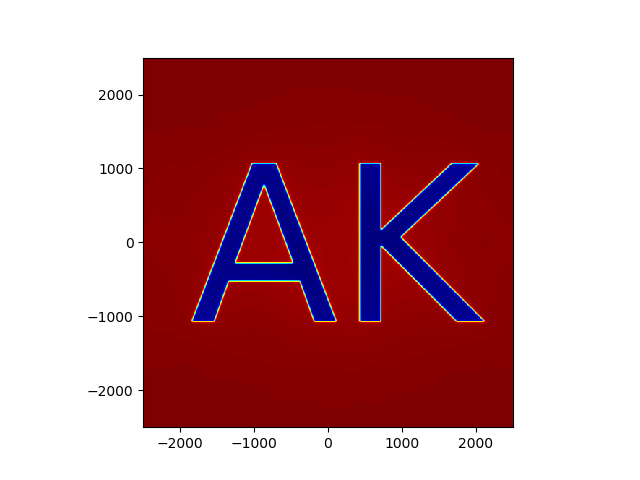

In [13]:
plt.imshow(z.real,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

<IPython.core.display.Javascript object>


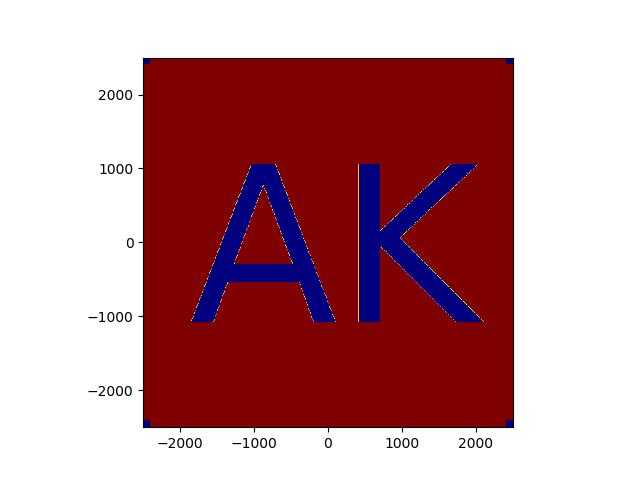

In [14]:
npix=10 #number of pixels to mod
dose_dis[:npix,:npix]=0 #upper-left
dose_dis[-npix:,:npix]=0 #lower-left
dose_dis[-npix:,-npix:]=0 #lower-right
dose_dis[:npix,-npix:]=0 #lower-right

plt.imshow(dose_dis,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

In [ ]:
ndiv=32 # number of div
test=np.empty((NP,NP),np.float64)
#test=dose_dis[NP//ndiv+1:,:NP//ndiv-1] #lower-left
#test=dose_dis[NP//ndiv+1:,NP//ndiv-1:] #lower-right
#test=dose_dis[:NP//ndiv+1,NP//ndiv-1:] #upper-right
test=dose_dis[:NP//ndiv+1,:NP//ndiv-1] #upper-left

plt.imshow(test,origin='upper', extent=[-WF/2/ndiv, WF/2/ndiv, -WF/2/ndiv, WF/2/ndiv],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

In [15]:
os.chdir("splittest")

In [16]:
#test save partial to files
ndiv=8 # number of div
for l in range(ndiv):
    for c in range(ndiv):
        filename="test_l"+str(l)+"_c"+str(c)
        test = dose_dis[l*NP//ndiv:(l+1)*NP//ndiv+1,c*NP//ndiv:(c+1)*NP//ndiv+1]
        np.save(filename,test)

In [17]:
#test load partial from files
ndiv=8 # number of div
test=np.empty((NP,NP),np.float64)
for l in range(ndiv):
    for c in range(ndiv):
        filename="test_l"+str(l)+"_c"+str(c)
        test[l*NP//ndiv:(l+1)*NP//ndiv+1,c*NP//ndiv:(c+1)*NP//ndiv+1]=np.load(filename+'.npy')

<IPython.core.display.Javascript object>


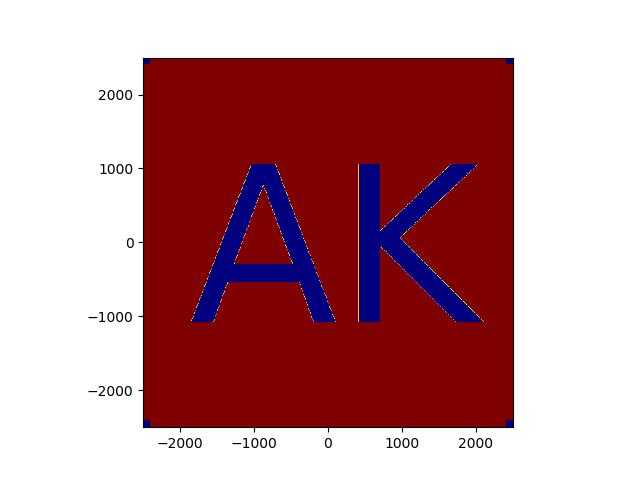

In [18]:
plt.imshow(test,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

In [74]:
os.chdir('../testsplitpsf')
#os.chdir('/media/luan/Data/dev/ebl/test/testsplitpsf')
os.getcwd()

'/media/luan/Data/dev/ebl/test/testsplitpsf'

In [79]:
#test save partial psf to files
NP=2048;WF=5000
ndiv=32 # number of div
BIG_NP = NP * ndiv

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] indices.
pixel_size=np.float32(WF/BIG_NP) if pixel_centered else np.float32(WF/(BIG_NP-1))

blockdim = (32, 16)
griddim = (int(NP/blockdim[0]),int(NP/blockdim[1]))

in_gpu = cuda.to_device(mcdata)

for l in range(ndiv):
    for c in range(ndiv):
        filename="psf_l"+str(l)+"_c"+str(c)
        psf = np.zeros((NP, NP), dtype = np.float64)
        out_gpu = cuda.to_device(psf)
        xmin = -WF/2 + c*pixel_size*NP
        ymin = -WF/2 + l*pixel_size*NP
        partial_psf_kernel[griddim, blockdim](out_gpu,pg.dotPattern(0,0)[0],NP,xmin,ymin,pixel_size,sr,nr,in_gpu) 
        out_gpu.to_host()
        np.save(filename,psf)
        out_gpu.gpu_data._mem.free()

In [67]:
#test load partial psf from files
psf=np.empty((BIG_NP,BIG_NP),np.float64)
for l in range(ndiv):
    for c in range(ndiv):
        filename="psf_l"+str(l)+"_c"+str(c)
        psf[l*BIG_NP//ndiv:(l+1)*BIG_NP//ndiv,c*BIG_NP//ndiv:(c+1)*BIG_NP//ndiv]=np.load(filename+'.npy')

<IPython.core.display.Javascript object>


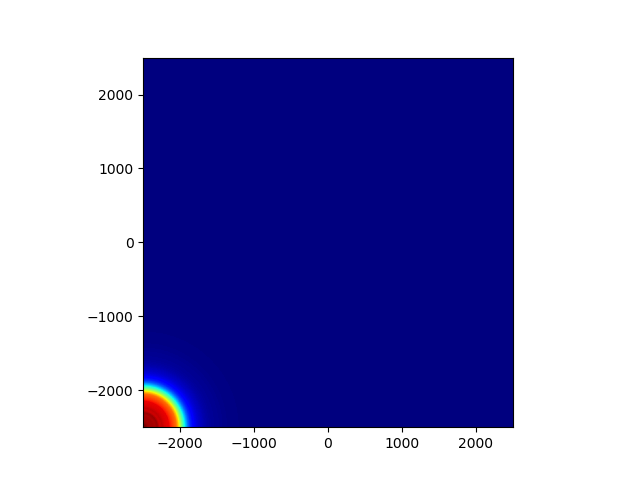

In [99]:
plt.imshow(psf,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

In [72]:
psf.min(),psf.max(),psf.shape

(0.0, 0.19314753607635882, (2048, 2048))

In [95]:
filename="psf_l"+str(15)+"_c"+str(16)
psf=np.load(filename+'.npy')

In [100]:
psf.dtype

dtype('float64')